In [1]:
import numpy as np
import readdy
import os
import sys
import matplotlib.pyplot as plt
import MDAnalysis as md
import MDAnalysis.analysis.rms
from scipy import stats
from readdy.api.utils import load_trajectory_to_npy
plt.style.use("mystyle-paper.mplstyle")

N_PD=10

In [2]:
Eav=[0.0,10.0]
Eav=[0.0,10.0]
rep=[1.0,2.0,3.0,4.0,5.0,6.0,7.0]
#rep=[1.0]

In [3]:
rep

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [4]:
def get_F(data,bin_n=100):
    [hist,hist_e]=np.histogram(data,bins=bin_n,density=True)
    bincenters = np.mean(np.vstack([hist_e[0:-1],hist_e[1:]]), axis=0)
    return [bincenters,-0.593*np.log(hist)]

In [5]:
dist=[]
for Ea in Eav:
    tmp=[]
    for r in rep:
        n_particles_per_frame, positions, types, ids = load_trajectory_to_npy(
        f"dimer_para_{Ea}_{r}_20.h5",begin=0,stride=10)
        #trajectory = readdy.Trajectory(f"dimer_para_{Ea}_{r}_10.h5")
        #trajectory.convert_to_xyz(particle_radii={'MCP': 60,'PD':1})
        #n_particles_per_frame, positions, types, ids = trajectory.to_numpy(start=1000)
        tmp.append(np.linalg.norm((positions[1:,1]-positions[1:,0])/30,axis=1))
    dist.append(tmp)

(array([3999., 3566., 3780., 4063., 3605., 2707., 1520.,  579.,  140.,
          41.]),
 array([1.94857762, 2.72851394, 3.50845025, 4.28838656, 5.06832288,
        5.84825919, 6.6281955 , 7.40813181, 8.18806813, 8.96800444,
        9.74794075]),
 <BarContainer object of 10 artists>)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


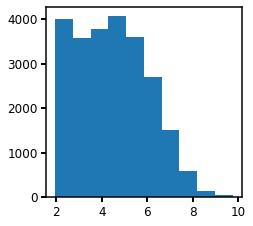

In [6]:
plt.hist(dist[0][0])

(array([3209., 3917., 4436., 4339., 3552., 2519., 1377.,  498.,  134.,
          19.]),
 array([ 1.94745736,  2.7551205 ,  3.56278363,  4.37044677,  5.17810991,
         5.98577304,  6.79343618,  7.60109932,  8.40876245,  9.21642559,
        10.02408873]),
 <BarContainer object of 10 artists>)

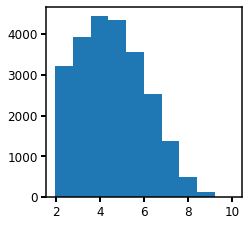

In [7]:
plt.hist(dist[1][0])

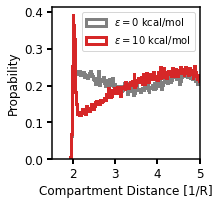

In [11]:
plt.figure(figsize=[2.65,2.8])
plt.hist(np.array(dist[0]).flatten(),bins=500,histtype='step',linewidth=3,label="$\epsilon=0$ kcal/mol",color="gray",density=1)
plt.hist(np.array(dist[1]).flatten(),bins=500,histtype='step',linewidth=3,label="$\epsilon=10$ kcal/mol",color="tab:red",density=1)
plt.legend()
plt.xlabel("Compartment Distance [1/R]")
plt.ylabel("Propability")
plt.xlim([1.5,5])
plt.xticks([2,3,4,5])
plt.savefig("mcp-mcp-dist.pdf")

<ipython-input-13-f754530591d6>:4: RuntimeWarning: divide by zero encountered in log
  return [bincenters,-0.593*np.log(hist)]
<ipython-input-13-f754530591d6>:4: RuntimeWarning: divide by zero encountered in log
  return [bincenters,-0.593*np.log(hist)]


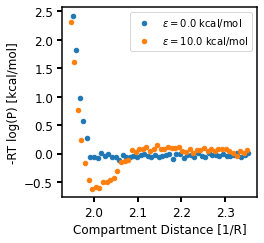

In [22]:
data=[np.array(dist[0]).flatten(),np.array(dist[1]).flatten()]
lables=["0.0","10.0"]
#plt.figure(figsize=[2,2])
for [d,l] in zip(data,lables):
    #plt.figure()
    x,y=get_F(d,1000)
    plt.plot(x[:50],np.subtract(y[:50],y[50]),'.',label=f"$\epsilon={l}$ kcal/mol")
    #plt.plot(x[:50],y[:50],'.')
    #plt.hist(-d,bins=100,log=True)
    #data.append(len(np.where(d<80)[0]))
    #data.append(np.median(d))
plt.ylabel("-RT log(P) [kcal/mol]")
plt.xlabel("Compartment Distance [1/R]")
plt.legend()

In [10]:
def calc_msd(file):
    traj = readdy.Trajectory(file)
    #times, positions = traj.read_observable_particle_positions()
    n_particles_per_frame, positions, types, ids = traj.to_numpy(start=500)

    times = np.arange(len(positions)) * 0.1 * 10000

    # convert to pure numpy array to make use of fancy operations
    T = len(positions)
    N = len(positions[0])
    N = 2
    pos = np.zeros(shape=(T, N, 3))
    for t in range(T):
        for n in range(N):
            pos[t, n, 0] = positions[t][n][0]
            pos[t, n, 1] = positions[t][n][1]
            pos[t, n, 2] = positions[t][n][2]

    # step 1.
    box_size = 200.
    box_indices = np.zeros(shape=(T, N, 3), dtype=int)
    for t in range(1, T):
        for n in range(N):
            for coord in [0, 1, 2]:
                delta = pos[t, n, coord] - pos[t-1, n, coord]
                if delta > 0.5 * box_size:
                    box_indices[t, n, coord] = box_indices[t-1, n, coord] - 1
                elif delta < - 0.5 * box_size:
                    box_indices[t, n, coord] = box_indices[t-1, n, coord] + 1
                else:
                    box_indices[t, n, coord] = box_indices[t-1, n, coord]

    # step 2.
    absolute_pos = np.zeros_like(pos)
    for t in range(T):
        for n in range(N):
            absolute_pos[t, n] = pos[t, n] + box_indices[t, n].astype(float) * box_size
    init_pos=absolute_pos[0,:]
    difference = absolute_pos - init_pos
    # sum over coordinates, per particle per timestep
    squared_displacements = np.sum(difference * difference, axis=2)
    # squared_displacements has shape (T,N)
    mean = np.mean(squared_displacements, axis=1)
    std_dev = np.std(squared_displacements, axis=1)
    std_err = np.std(squared_displacements, axis=1) / np.sqrt(squared_displacements.shape[1])

    # plot
    stride = 100
    plt.errorbar(times[::stride], mean[::stride], yerr=std_err[::stride], fmt=".", label="Particle diffusion")
    #plt.plot(times[::stride], 6. * times[::stride], label=r"$6 D t$")
    #plt.legend(loc="best")
    plt.xlabel(r"Time $t$")
    plt.ylabel(r"Mean squared displacement $\langle (x(t) - x_0)^2 \rangle_N$")
    plt.show()
    return mean[-1]/times[-1]/6


In [50]:
Ea=0.0
r=2.0

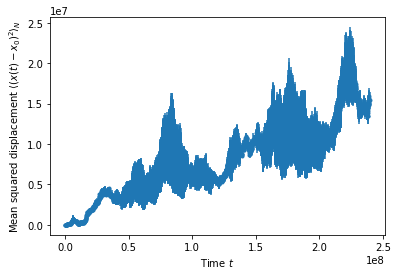

0.010724068236965577

In [51]:
calc_msd(f"dimer_para_{Ea}_{r}_20.h5")

In [13]:
Ea=10.0

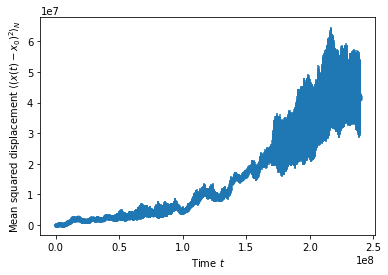

0.02911512587505812

In [15]:
calc_msd(f"dimer_para_{Ea}_{r}_20.h5")

In [77]:
0.011436593518838254/0.0038534758001453153

2.9678643676462113

In [13]:
Ea=10.0

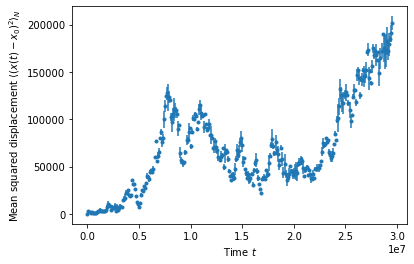

0.0011393593220305213

In [14]:
calc_msd(f"dimer_para_{Ea}.h5")

In [15]:
Ea=100.0

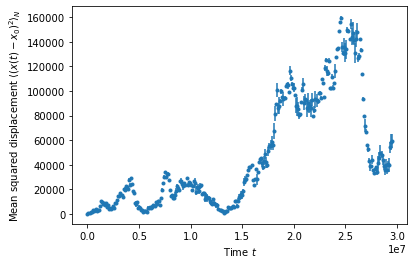

0.0003361129726926343

In [16]:
calc_msd(f"dimer_para_{Ea}.h5")

In [33]:
plt.style.use("mystyle-paper.mplstyle")

Text(0, 0.5, 'Distribution')

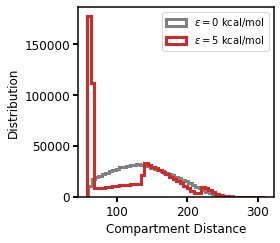

In [72]:
plt.hist(dist[0],bins=50,histtype='step',linewidth=3,label="$\epsilon=0$ kcal/mol",color="gray")
plt.hist(dist[3],bins=50,histtype='step',linewidth=3,label="$\epsilon=5$ kcal/mol",color="tab:red")
plt.legend()
plt.xlabel("Compartment Distance")
plt.ylabel("Distribution")

In [78]:
t = readdy.Trajectory("dimer_para_10.0_1.0_10.h5")

In [ ]:
t.convert_to_xyz()

In [158]:
def calc_msd_helper(file):
    traj = readdy.Trajectory(file)
    #times, positions = traj.read_observable_particle_positions()
    n_particles_per_frame, positions, types, ids = traj.to_numpy(start=500)

    #times = np.arange(len(positions)) * 0.1 * 10000

    # convert to pure numpy array to make use of fancy operations
    T = len(positions)
    N = len(positions[0])
    N = 1
    pos = np.zeros(shape=(T, N, 3))
    for t in range(T):
        for n in range(N):
            pos[t, n, 0] = positions[t][n][0]
            pos[t, n, 1] = positions[t][n][1]
            pos[t, n, 2] = positions[t][n][2]

    # step 1.
    box_size = 100.
    box_indices = np.zeros(shape=(T, N, 3), dtype=int)
    for t in range(1, T):
        for n in range(N):
            for coord in [0, 1, 2]:
                delta = pos[t, n, coord] - pos[t-1, n, coord]
                if delta > 0.5 * box_size:
                    box_indices[t, n, coord] = box_indices[t-1, n, coord] - 1
                elif delta < - 0.5 * box_size:
                    box_indices[t, n, coord] = box_indices[t-1, n, coord] + 1
                else:
                    box_indices[t, n, coord] = box_indices[t-1, n, coord]

    # step 2.
    absolute_pos = np.zeros_like(pos)
    for t in range(T):
        for n in range(N):
            absolute_pos[t, n] = pos[t, n] + box_indices[t, n].astype(float) * box_size
    init_pos=absolute_pos[0,:]
    difference = absolute_pos - init_pos
    # sum over coordinates, per particle per timestep
    squared_displacements = np.sum(difference * difference, axis=2)
    # squared_displacements has shape (T,N)
    return squared_displacements

def collect_D(base_name):
    #idx = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
    idx = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0]
    data=np.array([])
    for i in idx:
        file = f"{base_name}_{i}.h5"
        data = np.append(data,calc_msd_helper(file))
    samples=int(len(data)/len(idx))
    
    data=data.reshape(len(idx),samples)
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    std_err = np.std(data, axis=0) / np.sqrt(data.shape[0])
    times =np.arange(len(data[0])) * 0.1 * 10000

    # plot
    stride = 100
    plt.errorbar(times[::stride], mean[::stride], yerr=std_err[::stride],
                 fmt=".", label="Particle diffusion")
    #plt.plot(times[::stride], 6. * times[::stride], label=r"$6 D t$")
    plt.legend(loc="best")
    plt.xlabel(r"Time $t$")
    plt.ylabel(r"Mean squared displacement $\langle (x(t) - x_0)^2 \rangle_N$")
    plt.show()
    return [data,mean,std_dev]


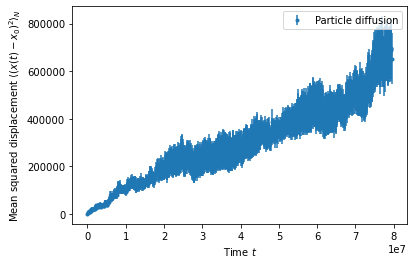

In [88]:
[data0,mean0,std_dev0]=collect_D("dimer_para_0.0")

In [95]:
times = np.arange(len(mean0)) * 0.1 * 10000 *0.1 

In [96]:
d=np.diff(mean0)/np.diff(times)
np.mean(d)/6

0.013684081848460296

In [97]:
mean0[-1]/times[-1]/6

0.013684081848480531

In [50]:
D_MCP=(25/2)**2/(4*3)*1E-12*1E9

In [51]:
D_MCP

0.013020833333333334

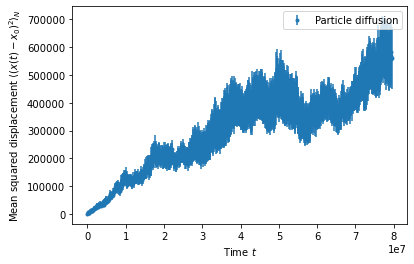

In [53]:
[data1,mean1,std_dev1]=collect_D("dimer_para_1.0")

In [112]:
d=np.diff(mean1)/np.diff(times)
np.mean(d)/6

0.011767939466992968

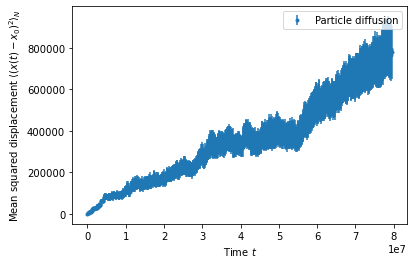

In [159]:
[data5,mean5,std_dev5]=collect_D("dimer_para_5.0")

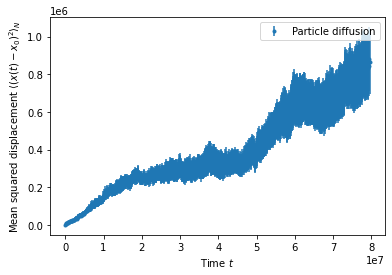

In [160]:
[data2,mean2,std_dev2]=collect_D("dimer_para_2.0")

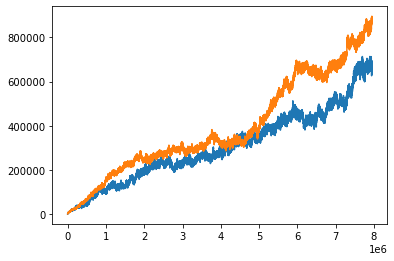

In [183]:
plt.plot(times,mean0)
#plt.plot(times,mean5)
plt.plot(times,mean2)

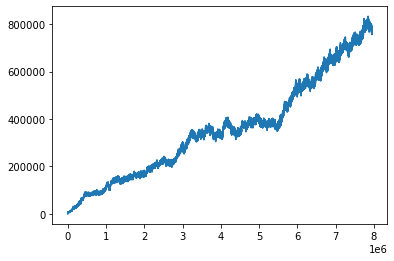

In [189]:
plt.plot(times,mean5)

In [170]:
d=np.diff(mean5)/np.diff(times)
np.mean(d[:])/6

0.016316924323099096

In [171]:
d=np.diff(mean10)/np.diff(times)
np.mean(d[:])/6

0.0026140980181082146

In [172]:
d=np.diff(mean1)/np.diff(times)
np.mean(d[:])/6

0.011767939466992968

In [173]:
d=np.diff(mean0)/np.diff(times)
np.mean(d[:])/6

0.013684081848460296

In [174]:
d=np.diff(mean2)/np.diff(times)
np.mean(d[:])/6

0.018162827206891035

In [180]:
d=np.diff(mean10)/np.diff(times)
np.mean(d[:])/6

0.0026140980181082146

In [21]:
from sklearn import linear_model

In [23]:
len(mean0)

79501

In [138]:
regr = linear_model.LinearRegression(fit_intercept=False)
data=mean0[-100:]
t=times[-100:]
# Train the model using the training sets
regr.fit(t.reshape(len(data),1), data)

LinearRegression(fit_intercept=False)

In [139]:
regr.coef_/6

array([0.01385599])

In [140]:
regr = linear_model.LinearRegression(fit_intercept=False)
data=mean1[-5000:]
t=times[-5000:]
# Train the model using the training sets
regr.fit(t.reshape(len(data),1), data)

LinearRegression(fit_intercept=False)

In [141]:
regr.coef_/6

array([0.01203715])

In [146]:
regr = linear_model.LinearRegression(fit_intercept=False)
data=mean10[-10:]
t=times[-10:]
# Train the model using the training sets
regr.fit(t.reshape(len(data),1), data)

LinearRegression(fit_intercept=False)

In [147]:
regr.coef_/6

array([0.00257756])

In [102]:
D_MCP

0.013020833333333334

In [119]:
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(times.reshape(len(mean10),1), mean5)

LinearRegression(fit_intercept=False)

In [120]:
regr.coef_/6h

array([0.01575735])

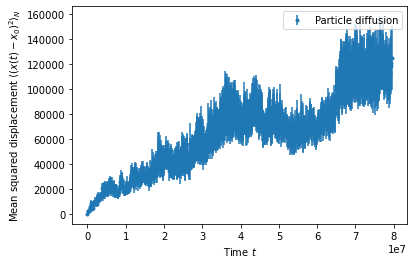

In [54]:
[data10,mean10,std_dev10]=collect_D("dimer_para_10.0")

In [72]:
800000000*0.1/times[-1]

10.062893081761006

In [73]:
times[-1]

7950000.0

In [74]:
800000000*0.1

80000000.0

In [94]:
800000000

800000000

In [93]:
80000000/times[-1]

10.062893081761006

In [ ]:
d=np.diff(mean)/np.diff(times)
np.mean(d[0:1000])

In [190]:
mean

array([0.00000000e+00, 1.78983156e+01, 4.49918114e+01, ...,
       4.26367974e+05, 4.26886108e+05, 4.29093103e+05])

In [ ]:
np.where(data==0)

In [35]:
data[29500]

IndexError: index 29500 is out of bounds for axis 0 with size 11

In [ ]:
data.reshape(6,29501)

In [ ]:
d=calc_msd_helper("dimer_para_0.0_0.0.h5")

In [ ]:
d=calc_msd_helper("dimer_para_0.0_3.0.h5")

In [ ]:
plt.plot(d)

In [ ]:
t1=np.array([])
t2=np.array([3,4,5])

In [ ]:
t3=np.hstack((t1,t2))

In [ ]:
np.mean(t3,axis=1)

In [ ]:
trajectory = readdy.Trajectory(f"dimer_para_1.0.h5")

In [ ]:
n_particles_per_frame, positions, types, ids = trajectory.to_numpy(start=10)

In [ ]:
plt.hist(np.linalg.norm(positions[:,1]-positions[:,0],axis=1))

In [ ]:
trajectory.convert_to_xyz(particle_radii={'MCP': 75,'PD':1})

In [ ]:
np.min(dist[2])

In [ ]:
np.min(dist[4])

In [ ]:
len(trajectory.read_observable_energy(data_set_name="energy")[1])

In [ ]:
len(positions)